In [322]:
## Setting up the mediawiki client for the categories
import mwclient
site = mwclient.Site('en.wikipedia.org')

import bz2
import json
import ijson
import requests
from fuzzywuzzy import fuzz
from bs4 import BeautifulSoup
from collections import Counter

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from tqdm import tqdm
tqdm.pandas()

/home/harshdee/.local/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
sns.set_style('darkgrid')

In [413]:
citations_bias_features = pd.read_parquet('citations_bias_features.parquet/', engine='pyarrow')

In [4]:
citations_bias_features.head()

,URL,tld,citations,Title,sub_domain,sections,type_of_citation,ID_list,id,r_id,r_parentid,page_title,page_id,ref_index,total_words,neighboring_words,neighboring_tags,bias_score,sub_dom
0,http://news.bbc.co.uk/2/hi/africa/8304282.stm,bbc,{{cite news|title=Congo and Angola 'end expuls...,Congo and Angola 'end expulsions',news,Initial Section,cite news,None,710,950413903,950313138.0,Foreign relations of Angola,710,2259,12705,"[tit-for-tat, '', ref, name=, '', Bearak, '', ...","[JJ, '', NN, NN, '', NNP, '', NN, NN, NNP, NN,...",-0.6358,news
1,https://timesofindia.indiatimes.com/entertainm...,indiatimes,{{Cite web|url=https://timesofindia.indiatimes...,Filmfare Awards Winners 1974: Complete list of...,timesofindia,Initial Section,cite web,None,1828,951787334,951509258.0,Amitabh Bachchan,1828,4261,23481,"[and, scripted, by, Biresh, Chatterjee, addres...","[CC, VBN, IN, NNP, NNP, VBG, NNS, IN, NN, ., P...",-0.9030,timesofindia
2,https://timesofindia.indiatimes.com/entertainm...,indiatimes,{{Cite web|url=https://timesofindia.indiatimes...,Filmfare Awards Winners 1974: Complete list of...,timesofindia,Initial Section,cite web,None,1828,951787334,951509258.0,Amitabh Bachchan,1828,4261,23481,"[and, scripted, by, Biresh, Chatterjee, addres...","[CC, VBN, IN, NNP, NNP, VBG, NNS, IN, NN, ., P...",-0.9446,timesofindia
3,https://www.theguardian.com/music/2015/feb/22/...,theguardian,{{Cite news |url=https://www.theguardian.com/m...,Public Service Broadcasting: The Race for Spac...,music,In popular culture,cite news,None,1965,953308828,952520940.0,Apollo 1,1965,15906,16507,"[the, Public, Service, Broadcasting, band, Pub...","[DT, NNP, NNP, NNP, NNP, NNP, NNP, NNP, NN, NN...",-1.3503,music
4,http://www.thecanadianencyclopedia.com/en/arti...,thecanadianencyclopedia,{{cite encyclopedia |title=College Songs and S...,College Songs and Songbooks,en,Initial Section,cite encyclopedia,None,2236,944933372,942207829.0,Acadia University,2236,3555,5554,"[University, fight, song, ., According, to, 'S...","[NNP, NN, NN, ., VBG, TO, NNS, IN, NNP, NNP, N...",-0.6380,en


Most of the cells are either in the range from `MODR` (from 0.5 to -0.5) or in the `LIBR` from (-0.5 to -2), with very less citations present as the ground truth for liberal

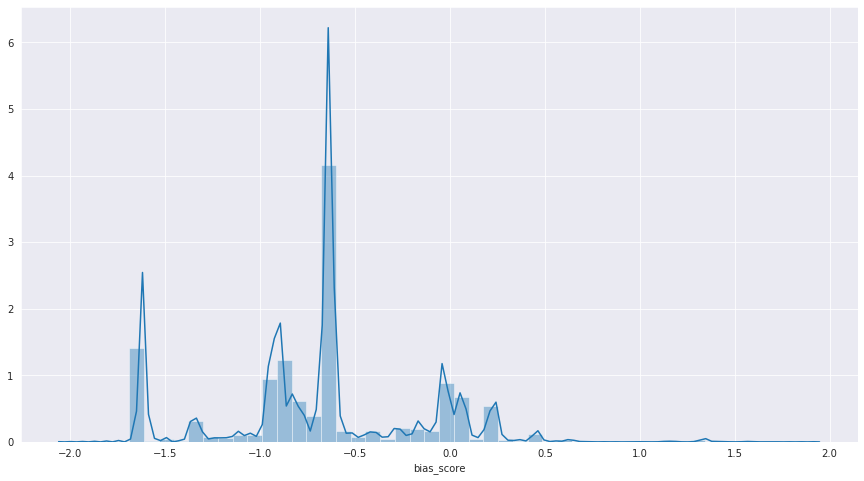

In [13]:
## plot the distribution of the bias score
plt.figure(figsize=(15,8))
ax = sns.distplot(citations_bias_features['bias_score'])

In [14]:
potential_cons_citations = citations_bias_features[citations_bias_features['bias_score'] > 0.5].shape[0]
print('Total number of possible conservative citations are: {}'.format(
    potential_cons_citations))
print('Percentage of citations: {}'.format((potential_cons_citations / citations_bias_features.shape[0]) * 100.0))

Total number of possible conservative citations are: 7380
Percentage of citations: 0.7900593829186592


In [15]:
## Citations with Joe Biden in the page title they are associated with
biden_citations = citations_bias_features[citations_bias_features['page_title'].progress_apply(
    lambda x: 'Joe Biden' in x)]
## Citations with Donald Trump in the page title they are associated with
donald_citations = citations_bias_features[citations_bias_features['page_title'].progress_apply(
    lambda x: 'Donald Trump' in x)]

print('Total number of citations associated with Biden: {}'.format(biden_citations.shape[0]))
print('Total number of citations associated with Trump: {}'.format(donald_citations.shape[0]))

100%|██████████| 934107/934107 [00:01<00:00, 740248.77it/s]

Total number of citations associated with Biden: 125
Total number of citations associated with Trump: 1345


Plot on the left is for the citations containing the word `Joe Biden` and on the right for `Donald Trump`, and as we can see both figures have more liberal sources cited than the conservative sources.

Text(0.5, 1.0, 'President Trump')

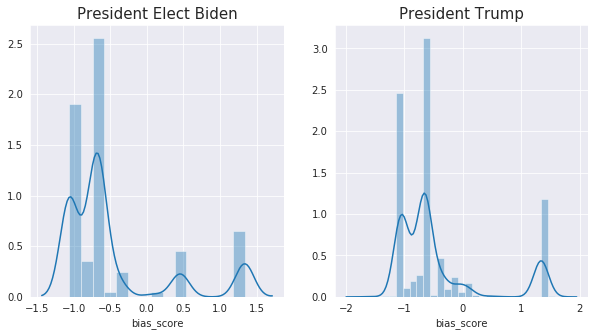

In [278]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
## Normalize the count so the area of the histogram is 1 and can be used with a common axis
sns.distplot(biden_citations['bias_score'], norm_hist=True, ax=ax1) # binwidth=0.2, ax=ax1)
ax1.set_title('President Elect Biden', fontsize=15)
sns.distplot(donald_citations['bias_score'], norm_hist=True, ax=ax2) # binwidth=0.2, ax=ax2)
ax2.set_title('President Trump', fontsize=15)

### Getting the categories for this dataset

This can be seen as to which categories are more prominent across which of the political bias scores

In [21]:
## Get all the category for each of the pages
# categories_dict = {}
# unique_pages = citations_bias_features['page_title'].unique()
# for p_no in tqdm(range(citations_bias_features['page_title'].nunique())):
#     p_title = unique_pages[p_no]
#     categories_dict[p_title] = [cat.name for cat in site.pages[p_title].categories()]

In [79]:
categories_dict = {}

In [85]:
## Reading the dump provided by DLAB to get all the category data out
## !bzip2 -d /dlabdata1/tmp/enwiki.labeled_article_items.json.bz2
data = ijson.parse(open('/dlabdata1/tmp/enwiki.labeled_article_items.json', 'r'), multiple_values=True)
current_article_pid = None

/home/harshdee/.local/lib/python3.7/site-packages/ijson/compat.py:48: DeprecationWarning: 
ijson works by reading bytes, but a string reader has been given instead. This
probably, but not necessarily, means a file-like object has been opened in text
mode ('t') rather than binary mode ('b').

An automatic conversion is being performed on the fly to continue, but on the
other hand this creates unnecessary encoding/decoding operations that decrease
the efficiency of the system. In the future this automatic conversion will be
removed, and users will receive errors instead of this warning. To avoid this
problem make sure file-like objects are opened in binary mode instead of text
mode.

  warnings.warn(_str_vs_bytes_warning, DeprecationWarning)


In [86]:
## Getting the categories from the drump for each of article PID
for prefix, event, value in data:
    if prefix == 'article_pid':
        current_article_pid = value
        categories_dict.setdefault(current_article_pid, [])
    if prefix == 'taxo_labels.item':
        categories_dict[current_article_pid].append(value)

In [89]:
citations_bias_features['categories'] = citations_bias_features['id'].progress_apply(
    lambda x: categories_dict.get(x, None))


100%|██████████| 934107/934107 [00:02<00:00, 421524.97it/s]


In [97]:
citations_categories_not_null = citations_bias_features[~citations_bias_features['categories'].isnull()]
print('The total number of citations with no categories: {}'.format(
    citations_bias_features.shape[0] - citations_categories_not_null.shape[0]))

The total number of citations with no categories: 48328


In [101]:
citations_categories_not_null['discretized_score'] = pd.cut(
    citations_categories_not_null['bias_score'],
    bins=[-2.0, -1.6, -1.2, -0.8, -0.4, 0, 0.4, 0.8, 1.2, 1.6, 2.0], 
    labels=['LIBR', '-4', '-3', '-2', '-1', 'MODR', '1', '2', '3', 'CONS'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [111]:
aggregated_discretized_cat = citations_categories_not_null[['discretized_score', 'categories']].groupby(
    'discretized_score')['categories'].apply(list).reset_index()

In [115]:
aggregated_discretized_cat['count_categories'] = aggregated_discretized_cat['categories'].progress_apply(
    lambda x: Counter([item for sublist in x for item in sublist])
)


100%|██████████| 10/10 [00:01<00:00,  8.94it/s][A


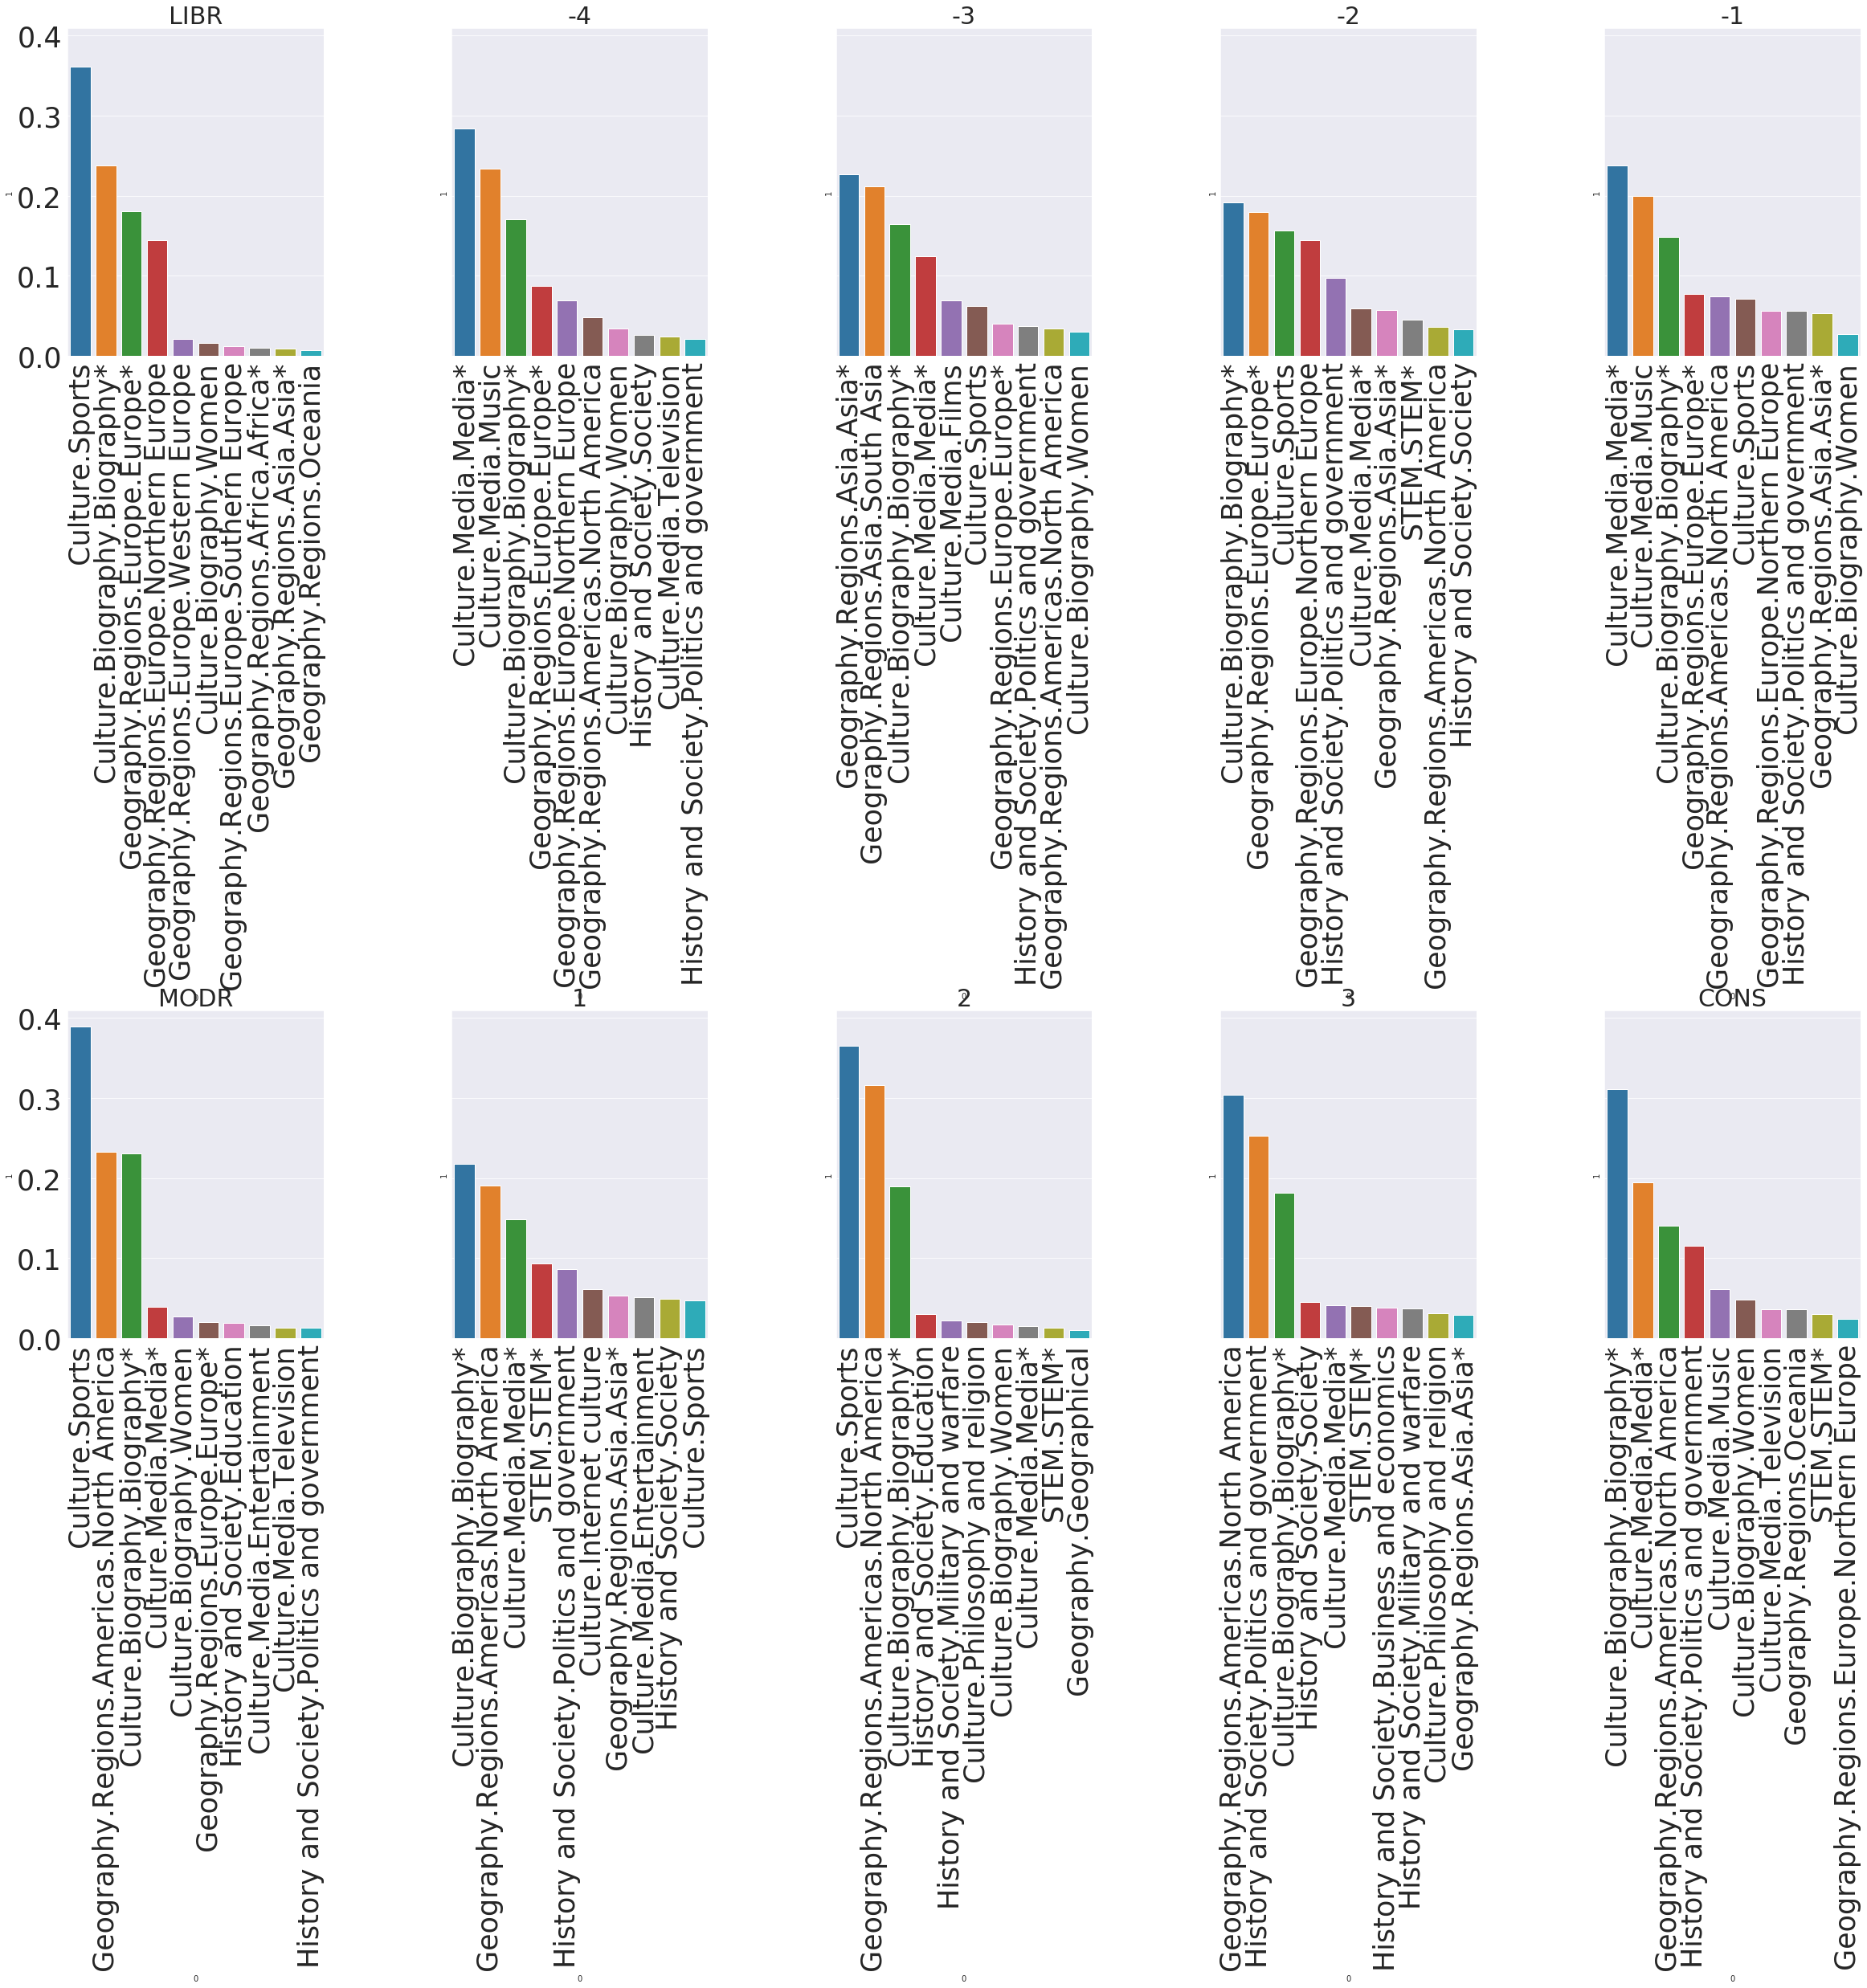

In [546]:
fig, axes = plt.subplots(2, 5, figsize=(40,30), sharey=True)
plt.subplots_adjust(wspace=0.5, hspace=2)
axes = axes.flatten()

discretized_labels = list(aggregated_discretized_cat['discretized_score'])

for index in range(len(discretized_labels)):
    discretized_label_score = aggregated_discretized_cat[
        aggregated_discretized_cat['discretized_score'] == discretized_labels[index]][
        'count_categories'].values[0].most_common(10)
    subset_cat = pd.DataFrame(discretized_label_score)
    sum_subset_cat = subset_cat[1].sum()
    subset_cat[1] = subset_cat[1].apply(lambda x: float(x) / sum_subset_cat)
    ax = sns.barplot(x=0, y=1, data=subset_cat, ax=axes[index])
    ax.set_title(discretized_labels[index], fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=35)
    ax.tick_params(axis='both', which='minor', labelsize=35)

    for item in ax.get_xticklabels():
        item.set_rotation(90)
        
fig.savefig('output_categories.png', dpi=300)

In [272]:
citations_with_NA = citations_bias_features[citations_bias_features['categories'].apply(
    lambda x: True if ((x is not None) and ('Geography.Regions.Americas.North America') in x) else False)]

citations_with_NEUR = citations_bias_features[citations_bias_features['categories'].apply(
    lambda x: True if ((x is not None) and ('Geography.Regions.Europe.Northern Europe') in x) else False)]

citations_with_EUR.shape, citations_with_NA.shape

((178493,), (117157, 20))

Text(0.5, 1.0, 'North Europe')

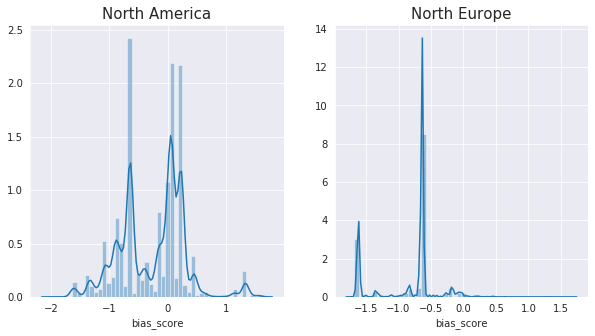

In [276]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
## Normalize the count so the area of the histogram is 1 and can be used with a common axis
sns.distplot(citations_with_NA['bias_score'], norm_hist=True, ax=ax1)
ax1.set_title('North America', fontsize=15)
sns.distplot(citations_with_NEUR['bias_score'], norm_hist=True, ax=ax2)
ax2.set_title('North Europe', fontsize=15)

### Reliability of sources

- From a journalistic perspective: https://thetrustproject.org/ (nice 8 pointers for checking out the reliability)
- The Iffy.news Index of Unreliable Sources is a resource for researchers needing a database of untrustworthy online sources, based on factual-reporting ratings by Media Bias/Fact Check, the professional news/info website reviewer.
- Interesting EMNLP paper: https://github.com/ramybaly/News-Media-Reliability


- https://mediabiasfactcheck.com/methodology/ - Factual Reporting and understanding of the labels

In [502]:
## Remove globo and youtube and consider traditional news outlets
## Since reliability is only for news outlets and not for aggregators
citations_bias_features = citations_bias_features[~citations_bias_features['tld'].isin([
    'globo', 'youtube', 'flickr', 'google', 'uol', 'yahoo', 'facebook', 'nhl', 'minorleaguebaseball', 'soonersports'])]

In [414]:
## Wrote a parser in Selenium to give the 
mbfc_data = pd.read_csv('/dlabdata1/harshdee/mbfc_data.csv')

In [415]:
mbfc_data.head()

,News Source,Bias,Reporting,Country,References
0,Syria News,Questionable Sources,Low,Unknown or Invalid Region,0
1,100% Fed up,Questionable Sources,Low,United States,"97,906"
2,10News.one,Questionable Sources,Low,United States,"2,011"
3,24 News,Questionable Sources,Low,United States,527
4,247 News Media,Questionable Sources,Very Low,Macedonia,213


In [416]:
## There are basically 6 main labels -- for reliability of news outlets
## Check the description in the link above for getting an outlook
print('Total number of news outlets: {}'.format(mbfc_data.shape[0]))
print('Set of reliable giveaway labels: {}'.format(mbfc_data['Reporting'].unique()))

Total number of news outlets: 3203
Set of reliable giveaway labels: ['Low' 'Very Low' 'Mixed' 'High' 'Mostly Factual' 'Very High']


In [417]:
mbfc_data['News Source'] = mbfc_data['News Source'].progress_apply(lambda x: x.lower())









100%|██████████| 3203/3203 [00:00<00:00, 336548.82it/s]


In [428]:
def find_the_closest_news(news_outlet):
    matches_with_perc = [
        (word, fuzz.token_set_ratio(word, news_outlet))
        for i, word in enumerate(mbfc_data['News Source'].unique())]
    max_percs = max([j for _, j in matches_with_perc])
    return [i for i, j in matches_with_perc if j == max_percs][0]

In [440]:
top_libr_news_outlets = citations_bias_features[citations_bias_features['bias_score'] < -0.5].groupby(
    'tld').count().reset_index().sort_values(['id'], ascending=False)[:10]

In [442]:
top_libr_news_outlets[['tld', 'URL']]

,tld,URL
71,bbc,383303
344,indiatimes,114206
699,theguardian,39200
133,cnn,15760
681,telegraph,11822
391,latimes,9530
341,india,7952
160,dailymail,4803
789,washingtonpost,3822
694,thecanadianencyclopedia,3613


In [455]:
map_mbfc_libr_tld = {}
for tld_ in list(top_libr_news_outlets['tld']):
    map_mbfc_libr_tld[tld_] = find_the_closest_news(tld_)
    
## Changes to names
map_mbfc_libr_tld['cnn'] = 'cnn'
map_mbfc_libr_tld['india'] = 'india.com'
map_mbfc_libr_tld['telegraph'] = 'daily telegraph (uk)'

In [464]:
map_mbfc_libr_tld

{'bbc': 'bbc news',
 'indiatimes': 'india times',
 'theguardian': 'the guardian',
 'cnn': 'cnn',
 'telegraph': 'daily telegraph (uk)',
 'latimes': 'la times',
 'india': 'india.com',
 'dailymail': 'daily mail',
 'washingtonpost': 'huffington post',
 'thecanadianencyclopedia': 'encyclopedia britannica'}

In [535]:
top_libr_news_outlets['reliability'] = [
    mbfc_data[mbfc_data['News Source'] == i].values[0][2]
    for i in map_mbfc_libr_tld.values()]
sum_citations_libr = top_libr_news_outlets['URL'].sum()
top_libr_news_outlets['URL'] = top_libr_news_outlets['URL'].apply(lambda x: (x / sum_citations_libr) * 100.0)

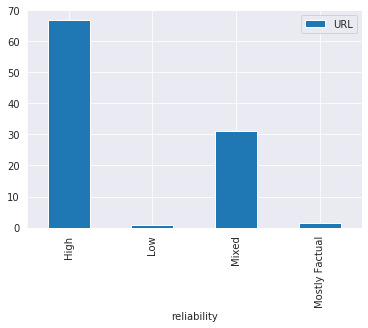

In [536]:
top_libr_news_outlets[['URL', 'reliability']].groupby('reliability').sum().plot.bar()

In [529]:
top_cons_news_outlets = citations_bias_features[citations_bias_features['bias_score'] > 0.5].groupby(
    'tld').count().reset_index().sort_values(['id'], ascending=False)[:6]

In [530]:
top_cons_news_outlets[['tld', 'URL']]

,tld,URL
33,foxnews,3290
58,kusports,203
81,people,163
15,beliefnet,128
57,kstatesports,65
12,army,51


In [531]:
map_mbfc_cons_tld = {}
for tld_ in list(top_cons_news_outlets['tld'])[:6]:
    map_mbfc_cons_tld[tld_] = find_the_closest_news(tld_)
del map_mbfc_cons_tld['kstatesports']
del map_mbfc_cons_tld['kusports']
top_cons_news_outlets = top_cons_news_outlets[~top_cons_news_outlets['tld'].isin(['kstatesports', 'kusports'])]

In [532]:
map_mbfc_cons_tld

{'foxnews': 'fox news',
 'people': 'american people daily',
 'beliefnet': 'beliefnet',
 'army': 'conservative army'}

In [537]:
top_cons_news_outlets['reliability'] = [
    mbfc_data[mbfc_data['News Source'] == i].values[0][2]
    for i in map_mbfc_cons_tld.values()]
sum_citations_cons = top_cons_news_outlets['URL'].sum()
top_cons_news_outlets['URL'] = top_cons_news_outlets['URL'].apply(lambda x: (x / sum_citations_cons) * 100.0)

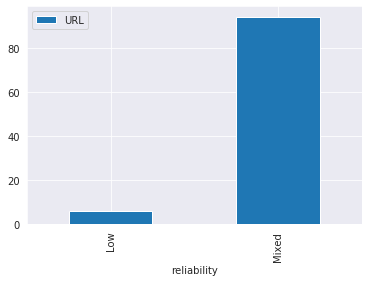

In [538]:
top_cons_news_outlets[['URL', 'reliability']].groupby('reliability').sum().plot.bar()